In [1]:
import numpy as np
import math
import random
#from scipy.stats import unitary_group as ug

In [2]:
def trap_bound(q, a, l):
    return 2 * a * ((2/(q**2 * (q**2 + 1))) ** (a//2 + l)) * ((2*q/(q**2 + 1)) ** l) / (1 - a * ((2*q/(q**2 + 1)) ** l)) * q ** (2*a + 4*l)

def partial_tr_bound(q, a, l):
    return 4 * (4 ** a) * a * ((2*q/(q**2 + 1)) ** (2*l))

In [3]:
#compute coefficients for entire circuit with product state input
#n should be even, l >= 2, q >= 2
def coeffs_product_state(q, n, l, lstep):
    #useful defs
    d = q**2
    w = q/(q**2 + 1)
    cn = 2**n
    cm = 2**(n//2)
    configs = {format(i, '0'+str(n)+'b'): i for i in range(cn)}
    lastconfig = {}
    for i in range(cm):
        rep = format(i, '0'+str(n//2)+'b')
        config = ''
        for j in range(n//2):
            config += rep[j] + rep[j]
        lastconfig[config] = configs[config]
    c = np.zeros(((l-1)*n//2 + 1, cn))
    for cii in lastconfig:
        c[0][lastconfig[cii]] = (1/d/(d+1))**(n//2)
    offset = -1
    nextconfig = {}
    for t in range(1, l):
        #print(t)
        offset *= -1
        for g in range(n//2 - 1):
            j = (t-1)*n//2 + g + 1
            #even layer: g, g-1 input
            #odd layer: g, g+1 input
            for config in lastconfig:
                if config[2*g + 1] == config[2*g + 1 + offset]:
                    nextconfig[config] = offset
                    c[j][configs[config]] += c[j - 1][configs[config]]
                elif offset > 0:
                    config1 = config[:2*g + 1] + '00' + config[2*g + 3:]
                    config2 = config[:2*g + 1] + '11' + config[2*g + 3:]
                    nextconfig[config1] = offset
                    nextconfig[config2] = offset
                    c[j][configs[config1]] += c[j - 1][configs[config]] * w
                    c[j][configs[config2]] += c[j - 1][configs[config]] * w
                else:
                    config1 = config[:2*g] + '00' + config[2*g + 2:]
                    config2 = config[:2*g] + '11' + config[2*g + 2:]
                    nextconfig[config1] = offset
                    nextconfig[config2] = offset
                    c[j][configs[config1]] += c[j - 1][configs[config]] * w
                    c[j][configs[config2]] += c[j - 1][configs[config]] * w
            #print(g)
            #print(lastconfig)
            #print(nextconfig)
            #print()
            lastconfig = nextconfig
            nextconfig = {}
        #last gate separately
        j = t*n//2
        g = -1
        for config in lastconfig:
            if config[2*g + 1] == config[2*g + 1 + offset]:
                nextconfig[config] = offset
                c[j][configs[config]] += c[j - 1][configs[config]]
            elif offset < 0:
                config1 = config[:-2] + '00'
                config2 = config[:-2] + '11'
                nextconfig[config1] = offset
                nextconfig[config2] = offset
                c[j][configs[config1]] += c[j - 1][configs[config]] * w
                c[j][configs[config2]] += c[j - 1][configs[config]] * w
            else:
                config1 = '0' + config[1:-1] + '0'
                config2 = '1' + config[1:-1] + '1'
                nextconfig[config1] = offset
                nextconfig[config2] = offset
                c[j][configs[config1]] += c[j - 1][configs[config]] * w
                c[j][configs[config2]] += c[j - 1][configs[config]] * w
        #print(lastconfig)
        #print(nextconfig)
        lastconfig = nextconfig
        nextconfig = {}
    #print(lastconfig)
    #print(c[-1])
    #print(np.sum(c[-1]) - c[-1][0] - c[-1][-1])
    return [c[lstep*i*n//2] for i in range(l//lstep)]

In [44]:
#returns configurations with domain wall in region of specified size, q = 2, n >= a
def configs_dw(n, a):
    result = {}
    configs = {format(i, '0'+str(n)+'b'): i for i in range(2**n)}
    s = (n - a)//2
    for cii in configs:
        if ('0' in cii[s:-s]) and ('1' in cii[s:-s]):
            result[cii] = configs[cii]
    return result

def configs_dw_ns(n, a):
    result = {}
    configs = {format(i, '0'+str(n)+'b'): i for i in range(2**n)}
    for cii in configs:
        if ('0' in cii[:a]) and ('1' in cii[:a]):
            result[cii] = configs[cii]
    return result

In [57]:
#compute trace norm given output coefficients
def coeffs_trace_norm(c, q, n, select):
    #TODO
    if len(c) != 2**n:
        print('Dimensions must match!')
        return -1
    if len(select) == 0:
        return 0
    if len(select[0]) != n:
        print('Dimensions must match!')
        return -1
    #swap has q + q(q-1)/2 eigenvectors with +1 and q(q-1)/2 eigenvectors with -1
    return -1

#compute trace norm given output coefficients, q = 2
def coeffs_trace_norm_2(c, n, select):
    if len(c) != 2**n:
        print('Dimensions must match!')
        return -1
    if len(select) == 0:
        return 0
    #swap has 3 eigenvectors with +1 and one with -1
    evs = [format(i, '0'+str(n)+'b') for i in range(2**n)]
    coeffs = {}
    for ci in select:
        if c[select[ci]] != 0:
            coeffs[ci] = c[select[ci]]
    result = 0
    #print([coeffs[ci] for ci in coeffs])
    for ev in evs:
        cosum = 0
        w = ev.count('1')
        for ci in coeffs:
            sign = 1
            for i in range(n):
                if ev[i] == '1' and ci[i] == '1':
                    sign *= -1
            cosum += sign * coeffs[ci]
        #print(w)
        result += (3**w) * abs(cosum)
        #print(cosum)
    return result

In [6]:
#compute coefficients for trapezoidal circuit
#a should be even, l >= 2, q >= 2
def coeffs_trap_product_state(q, a, l, lstep):
    #useful defs
    n = a + 2 * (l - 1)
    d = q**2
    w = q/(q**2 + 1)
    cn = 2**n
    cm = 2**(n//2)
    configs = {format(i, '0'+str(n)+'b'): i for i in range(cn)}
    lastconfig = {}
    for i in range(cm):
        rep = format(i, '0'+str(n//2)+'b')
        config = ''
        for j in range(n//2):
            config += rep[j] + rep[j]
        lastconfig[config] = configs[config]
    c = np.zeros(((l-1)*(n//2 + a//2 - 1)//2 + 1, cn))
    for cii in lastconfig:
        c[0][lastconfig[cii]] = (1/d/(d+1))**(n//2)
    offset = -1
    nextconfig = {}
    lsgates = [i for i in range(n//2 - 1)]
    j = 0
    for t in range(1, l):
        #print(t)
        offset *= -1
        for g in lsgates:
            j += 1
            #even layer: g, g-1 input
            #odd layer: g, g+1 input
            for config in lastconfig:
                if config[2*g + 1] == config[2*g + 1 + offset]:
                    nextconfig[config] = offset
                    c[j][configs[config]] += c[j - 1][configs[config]]
                elif offset > 0:
                    config1 = config[:2*g + 1] + '00' + config[2*g + 3:]
                    config2 = config[:2*g + 1] + '11' + config[2*g + 3:]
                    nextconfig[config1] = offset
                    nextconfig[config2] = offset
                    c[j][configs[config1]] += c[j - 1][configs[config]] * w
                    c[j][configs[config2]] += c[j - 1][configs[config]] * w
                else:
                    config1 = config[:2*g] + '00' + config[2*g + 2:]
                    config2 = config[:2*g] + '11' + config[2*g + 2:]
                    nextconfig[config1] = offset
                    nextconfig[config2] = offset
                    c[j][configs[config1]] += c[j - 1][configs[config]] * w
                    c[j][configs[config2]] += c[j - 1][configs[config]] * w
            #print(g)
            #print(lastconfig)
            #print(nextconfig)
            #print()
            lastconfig = nextconfig
            nextconfig = {}
        #print(lastconfig)
        #print(nextconfig)
        del lsgates[(offset - 1)//2]
        #print(lsgates)
    #print(lastconfig)
    #print(c[-1])
    #print(np.sum(c[-1]) - c[-1][0] - c[-1][-1])
    #print(j)
    return [c[lstep*i*(n - lstep*i - 1)//2] for i in range(l//lstep)]

In [ ]:
#compute coefficients for partial trace over output

In [11]:
q = 2
l = 10
lstep = 1
for n in [6, 8]:
    c = coeffs_product_state(q, n, l, lstep)
    print(n)
    f = open('output/coeffs_product_state_' + str(n) + '_' + str(l) + '_' + str(lstep), 'w')
    for t in range(len(c)):
        f.writelines('%s\n' % ci for ci in c[t])
        f.write('\n')
    f.close()
#dw = configs_dw(n, a)

6
8


In [40]:
for n in [10, 12, 14, 16, 18, 20, 22, 24]:
    for a in [8]:
        dw = configs_dw(n, a)
        with open('output/configs_dw_' + str(n) + '_' + str(a), 'w') as f:
            f.writelines('%s\n' % cii for cii in [dw[cii] for cii in dw])

In [238]:
c = coeffs_product_state(2, 8, 2, 1)[-1]
dw = configs_dw(8, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**8)

c = coeffs_product_state(2, 8, 4, 1)[-1]
dw = configs_dw(8, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**8)

c = coeffs_product_state(2, 8, 6, 1)[-1]
dw = configs_dw(8, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**8)

c = coeffs_product_state(2, 10, 2, 1)[-1]
dw = configs_dw(10, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**10)

c = coeffs_product_state(2, 10, 4, 1)[-1]
dw = configs_dw(10, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**10)

c = coeffs_product_state(2, 10, 6, 1)[-1]
dw = configs_dw(10, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**10)

2.479882240000001
0.7331556418912262
0.21875936041865396
3.628072960000002
1.1251311076966406
0.3750882323283421


In [55]:
c = coeffs_product_state(2, 14, 2, 1)[-1]
dw = configs_dw(14, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**14)

c = coeffs_product_state(2, 14, 3, 1)[-1]
dw = configs_dw(14, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**14)

c = coeffs_product_state(2, 14, 4, 1)[-1]
dw = configs_dw(14, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**14)

c = coeffs_product_state(2, 14, 5, 1)[-1]
dw = configs_dw(14, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**14)

c = coeffs_product_state(2, 14, 6, 1)[-1]
dw = configs_dw(14, 4)
print(np.sum([c[dw[ci]] for ci in dw]) * 4**14)

7.537774978662405
2.0342520373053503
2.003475038446715
0.6210692236753136
0.6934553422794508


In [71]:
q = 5
d = q**2
c = coeffs_trap_product_state(q, 4, 2, 1)
dw = configs_dw(6, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * d**6)

c = coeffs_trap_product_state(q, 4, 4, 1)
dw = configs_dw(10, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * d**10)

c = coeffs_trap_product_state(q, 4, 6, 1)
dw = configs_dw(14, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * d**14)

c = coeffs_trap_product_state(q, 4, 8, 1)
dw = configs_dw(18, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * d**18)

c = coeffs_trap_product_state(q, 4, 10, 1)
dw = configs_dw(22, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * d**22)

c = coeffs_trap_product_state(q, 4, 12, 1)
dw = configs_dw(26, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * d**26)

1.2230275348579154
0.7220146323083957
0.7192715036162945
0.718018888048598


KeyboardInterrupt: 

In [76]:
q = 4
c = coeffs_trap_product_state(q, 4, 2, 1)
dw = configs_dw(6, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * 16**6)
print(trap_bound(q, 4, 2))
print()

c = coeffs_trap_product_state(q, 4, 4, 1)
dw = configs_dw(10, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * 16**10)
print(trap_bound(q, 4, 4))
print()

c = coeffs_trap_product_state(q, 4, 6, 1)
dw = configs_dw(14, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * 16**14)
print(trap_bound(q, 4, 6))
print()

c = coeffs_trap_product_state(q, 4, 8, 1)
dw = configs_dw(18, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * 16**18)
print(trap_bound(q, 4, 8))
print()

c = coeffs_trap_product_state(q, 4, 10, 1)
dw = configs_dw(22, 4)
print(np.sum([c[-1][dw[ci]] for ci in dw]) * 16**22)
print(trap_bound(q, 4, 10))
print()

1.4539379669924506
194.78712557502328

1.0156160351072585
21.711725800546134

1.0298293915926116
14.316385110973101

1.030273889736587
10.849940346129092

1.0300990286498986
8.44966623726645



In [79]:
for l in range(12, 36, 6):
    print(trap_bound(q, 4, l))

6.619154490337659
3.196336779517964
1.5441982870706867
0.7460291166225692


In [18]:
c = coeffs_product_state(2, 16, 2, 1)[-1]
print(coeffs_trace_norm_2(c, 16, configs_dw(16, 4)))

0.7112725887999876


In [8]:
q = 4
for a in [4, 6, 8]:
    for l in [2, 4, 6, 8, 10]:
        c = coeffs_trap_product_state(q, a, l, 1)
        print(a, l)
        f = open('output/coeffs_trap_product_state_' + str(q) + '_' + str(a) + '_' + str(l) + '_1', 'w')
        for t in range(len(c)):
            f.writelines('%s\n' % ci for ci in c[t])
            f.write('\n')
        f.close()

4 2
4 4
4 6
4 8
4 10
6 2
6 4
6 6
6 8
6 10
8 2
8 4
8 6
8 8
8 10


In [10]:
q = 2
for a in [4, 6, 8]:
    for l in [2, 4, 6, 8, 10]:
        c = coeffs_trap_product_state(q, a, l, 1)
        print(a, l)
        f = open('output/coeffs_trap_product_state_' + str(q) + '_' + str(a) + '_' + str(l) + '_1', 'w')
        for t in range(len(c)):
            f.writelines('%s\n' % ci for ci in c[t])
            f.write('\n')
        f.close()

4 2
4 4
4 6
4 8
4 10
6 2
6 4
6 6
6 8
6 10
8 2
8 4
8 6
8 8
8 10


In [90]:
#compute 1-norm and triangle inequality bound for entire and trapezoid circuits, q = 2, a = 4
q = 2
a = 4
table = []
for l in [10]:
    n = a + 2*(l-1)
    f1 = open('output/coeffs_product_state_' + str(n) + '_10_1', 'r')
    c1 = list(map(float, f1.read().split('\n\n')[l-1].split('\n')))
    f1.close()
    f2 = open('output/coeffs_trap_product_state_' + str(q) + '_' + str(a) + '_' + str(l) + '_1', 'r')
    c2 = list(map(float, f2.read().split('\n\n')[l-1].split('\n')))
    f2.close()
    fc = open('output/configs_dw_' + str(n) + '_' + str(a), 'r')
    cc = fc.read().split('\n')
    fc.close()
    cc.pop()
    cc = list(map(int, cc))
    dw = {}
    for ci in cc:
        dw[format(ci, '0'+str(n)+'b')] = ci
    result = ''
    result += str(np.sum([c1[ci] for ci in cc]) * q**(2*n)) + ','
    result += str(coeffs_trace_norm_2(c1, n, dw)) + ','
    result += str(np.sum([c2[ci] for ci in cc]) * q**(2*n)) + ','
    result += str(coeffs_trace_norm_2(c2, n, dw))
    #full circuit triangle inequality, 1 norm; trapezoidal circuit triangle inequality, 1 norm
    table.append(result)
    print(result)
f = open('output/compare_2_4', 'a')
f.writelines('%s\n' % e for e in table)
f.close()

KeyboardInterrupt: 

In [91]:
result

'0.10230206107256114,0.01722551266379886,0.5524194375533759,'

In [ ]:
#compute 1-norm for entire and trapezoid circuits, q = 2, a = 6
q = 2
a = 6
table = []
for l in [2, 4, 6, 8, 10]:
    n = a + 2*(l-1)
    f1 = open('output/coeffs_product_state_' + str(n) + '_10_1', 'r')
    c1 = list(map(float, f1.read().split('\n\n')[l-1].split('\n')))
    f1.close()
    f2 = open('output/coeffs_trap_product_state_' + str(q) + '_' + str(a) + '_' + str(l) + '_1', 'r')
    c2 = list(map(float, f2.read().split('\n\n')[l-1].split('\n')))
    f2.close()
    fc = open('output/configs_dw_' + str(n) + '_' + str(a), 'r')
    cc = fc.read().split('\n')
    fc.close()
    cc.pop()
    cc = list(map(int, cc))
    dw = {}
    for ci in cc:
        dw[format(ci, '0'+str(n)+'b')] = ci
    result = ''
    result += str(np.sum([c1[ci] for ci in cc]) * q**(2*n)) + ','
    result += str(coeffs_trace_norm_2(c1, n, dw)) + ','
    print()
    result += str(np.sum([c2[ci] for ci in cc]) * q**(2*n)) + ','
    result += str(coeffs_trace_norm_2(c2, n, dw))
    #full circuit triangle inequality, 1 norm; trapezoidal circuit triangle inequality, 1 norm
    table.append(result)
    print(result)
with f as open('output/compare_' + str(q) + '_' + str(a), 'w'):
    f.writelines('%s\n' % e for e in table)

In [92]:
#compute 1-norm for trapezoid circuit, q = 4, a = 4
q = 4
a = 4
table = []
for l in [8, 10]:
    n = a + 2*(l-1)
    c1 = coeffs_product_state(q, n, l, 1)[-1]
    f2 = open('output/coeffs_trap_product_state_' + str(q) + '_' + str(a) + '_' + str(l) + '_1', 'r')
    c2 = list(map(float, f2.read().split('\n\n')[l-1].split('\n')))
    f2.close()
    fc = open('output/configs_dw_' + str(n) + '_' + str(a), 'r')
    cc = fc.read().split('\n')
    fc.close()
    cc.pop()
    cc = list(map(int, cc))
    dw = {}
    for ci in cc:
        dw[format(ci, '0'+str(n)+'b')] = ci
    result = ''
    result += str(np.sum([c1[ci] for ci in cc]) * q**(2*n)) + ','
    result += str(coeffs_trace_norm_2(c1, n, dw)) + ','
    print()
    result += str(np.sum([c2[ci] for ci in cc]) * q**(2*n)) + ','
    #result += str(coeffs_trace_norm_2(c2, n, dw))
    result += '-1'
    #full circuit triangle inequality, 1 norm; trapezoidal circuit triangle inequality, 1 norm
    table.append(result)
    print(result)
f = open('output/compare_' + str(q) + '_' + str(a), 'a')
f.writelines('%s\n' % e for e in table)
f.close()


0.00024052553377097496,6.698494303456092e-16,0.01588693145550357,-1

1.5011671607365877e-05,1.4640480452118844e-19,0.0036040471887592036,-1


In [88]:
#compute 1-norm for trapezoid circuit, q = 4, a = 6
#minimum depth for q = 4, a = 6 is l = 3
q = 4
a = 6
table = []
for l in [4, 6, 8, 10]:
    n = a + 2*(l-1)
    c1 = coeffs_product_state(q, n, l, 1)[-1]
    f2 = open('output/coeffs_trap_product_state_' + str(q) + '_' + str(a) + '_' + str(l) + '_1', 'r')
    c2 = list(map(float, f2.read().split('\n\n')[l-1].split('\n')))
    f2.close()
    fc = open('output/configs_dw_' + str(n) + '_' + str(a), 'r')
    cc = fc.read().split('\n')
    fc.close()
    cc.pop()
    cc = list(map(int, cc))
    dw = {}
    for ci in cc:
        dw[format(ci, '0'+str(n)+'b')] = ci
    result = ''
    result += str(np.sum([c1[ci] for ci in cc]) * q**(2*n)) + ','
    result += str(coeffs_trace_norm_2(c1, n, dw)) + ','
    print()
    result += str(np.sum([c2[ci] for ci in cc]) * q**(2*n)) + ','
    result += str(coeffs_trace_norm_2(c2, n, dw))
    #full circuit triangle inequality, 1 norm; trapezoidal circuit triangle inequality, 1 norm
    table.append(result)
    print(result)
f = open('output/compare_' + str(q) + '_' + str(a), 'w')
f.writelines('%s\n' % e for e in table)
f.close()


0.12226855948980012,1.272172601128958e-09,0.5915592743218699,5.112783835594321e-09



KeyboardInterrupt: 

In [154]:
import matplotlib.pyplot as plt
import matplotlib.font_manager

<Figure size 432x288 with 0 Axes>

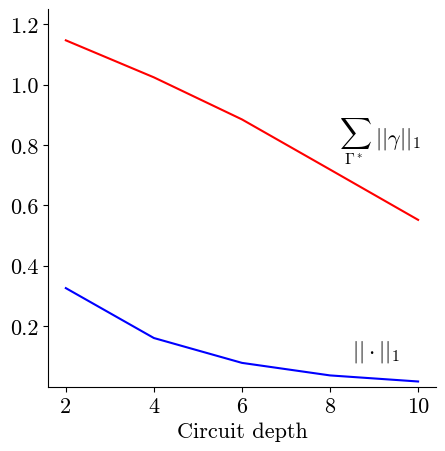

In [208]:
#plot 1-norm and triangle inequality bound for entire and trapezoid circuits, q = 2, a = 4
q = 2
a = 4
table = []
f = open('output/compare_' + str(q) + '_' + str(a), 'r')
for row in [2, 4, 6, 8, 10]:
    table.append(list(map(float, f.readline().split(','))))
f.close()
plt.clf()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot([2, 4, 6, 8, 10], [row[1] for row in table], color='b', linewidth=1.5)
plt.plot([2, 4, 6, 8, 10], [row[2] for row in table], color='r', linewidth=1.5)
plt.xlabel('Circuit depth')
#plt.ylabel('Label')
#plt.title('Title')
fig.set_size_inches(5, 5)
fig.set_dpi(100)
frame = plt.gca()
#frame.axes.get_yaxis().set_visible(False)
plt.rcParams.update({'font.size': 16})
#plt.rcParams.update({'font.family': 'cmss10', 'mathtext.fontset': 'stixsans'})
plt.rcParams.update({'font.family': 'cmr10', 'mathtext.fontset': 'cm'})
#plt.grid(True)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper right')
plt.ylim([0, 1.25])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1, 1.2])
plt.text(8.2, 0.8, r'$\sum_{\Gamma^*} \,\, \vert\vert\gamma\vert\vert_1$', horizontalalignment='left')
plt.text(8.5, 0.1, r'$\vert\vert\cdot\vert\vert_1$', horizontalalignment='left')
#plt.text(8.2, 0.8, r'$\sum_* \,\, \vert\vert\gamma\vert\vert_1$', horizontalalignment='left', fontsize=18)
#plt.text(8.5, 0.1, r'$\vert\vert\cdot\vert\vert_1$', horizontalalignment='left', fontsize=18)
#plt.xlim([2, 10.5])
#plt.show()
plt.savefig('plots/compare_2_4_r.pdf', bbox_inches='tight', pad_inches=0, transparent=True)

<Figure size 432x288 with 0 Axes>

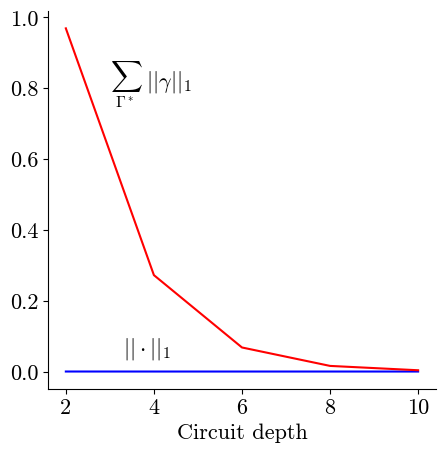

In [211]:
#plot triangle inequality bound, 1-norm, and analytic bound for trapezoid circuit, q = 4, a = 4
q = 4
a = 4
table = []
f = open('output/compare_' + str(q) + '_' + str(a), 'r')
for row in [2, 4, 6, 8, 10]:
    table.append(list(map(float, f.readline().split(','))))
f.close()
plt.clf()
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot([2, 4, 6, 8, 10], [row[1] for row in table], color='b', linewidth=1.5)
plt.plot([2, 4, 6, 8, 10], [row[2] for row in table], color='r', linewidth=1.5)
plt.xlabel('Circuit depth')
#plt.ylabel('Label')
#plt.title('Title')
fig.set_size_inches(5, 5)
fig.set_dpi(100)
frame = plt.gca()
#frame.axes.get_yaxis().set_visible(False)
plt.rcParams.update({'font.size': 16})
#plt.rcParams.update({'font.family': 'cmss10', 'mathtext.fontset': 'stixsans'})
plt.rcParams.update({'font.family': 'cmr10', 'mathtext.fontset': 'cm'})
#plt.grid(True)
#plt.legend(bbox_to_anchor=(1, 0.85), loc='upper right')
#plt.ylim([0, 1.05])
#plt.yticks([0.2, 0.4, 0.6, 0.8, 1])
#plt.xlim([2, 10.5])
#plt.text(3, 0.8, r'$\sum_* \,\, \vert\vert\gamma\vert\vert_1$', horizontalalignment='left', fontsize=18)
#plt.text(3.3, 0.05, r'$\vert\vert\cdot\vert\vert_1$', horizontalalignment='left', fontsize=18)
plt.text(3, 0.8, r'$\sum_{\Gamma^*} \,\, \vert\vert\gamma\vert\vert_1$', horizontalalignment='left')
plt.text(3.3, 0.05, r'$\vert\vert\cdot\vert\vert_1$', horizontalalignment='left')
#plt.show()
plt.savefig('plots/compare_4_4_r.pdf', bbox_inches='tight', pad_inches=0, transparent=True)